# Face Emotion Recognition

### Project Introduction
The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms. Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge. In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (ex- Zoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to a lack of surveillance. While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts which can be analyzed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analyzed and tracked.

We will solve the above-mentioned challenge by applying deep learning algorithms to live video data.The solution to this problem is by recognizing facial emotions.

### Importing Libraries
Importing the required python libraries like numpy, seaborn, matplotlib, tensorflow

In [2]:
# Importing all the required Libraries

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential                                                            
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np 
import cv2
import os

# Removing all those annoying Warnings

import warnings                                                                                
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
#dowload the data and add the path
my_data_dir = 'C:\\Users\\Ultimatrix\\Downloads\\face_recog\\data'

In [4]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

['test', 'train']

In [5]:
#setting up test and train path
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [6]:
#list the directory of test path
os.listdir(test_path)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [7]:
#list the directory of trian path
os.listdir(train_path)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [8]:
#getting the first image of angry folder
os.listdir(train_path+'\\angry')[0]

'Training_10118481.jpg'

In [9]:
img =train_path+'\\angry'+'\\Training_10118481.jpg'

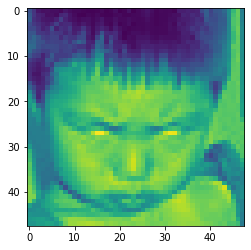

In [10]:
#showing the first image of angry folder
plt.imshow(imread(img))

## Setup the data generators
Now we will generate training and testing (validation) batches.

### Image Manipulation

Its usually a good idea to manipulate the images with scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us

In [11]:
# Creating Image generators, for all train, validation, and test set
training_gen=ImageDataGenerator(rescale=1./255)
testing_gen=ImageDataGenerator(rescale=1./255)

In [13]:
# Creating  Training Dataset

train_gen=training_gen.flow_from_directory(train_path,                
                                           target_size=(48,48),
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical')

# Creating Test Set

test_gen=testing_gen.flow_from_directory(test_path,                                       
                                           target_size=(48,48),  
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical',
                                           shuffle= False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


- Deep learning models are trained by being fed with batches of data. Keras has a very useful class to automatically feed data from a directory: ImageDataGenerator.
As of now we have imported libraries, got dataset, and created train and test images.

In [15]:
#printing the class indicies og train_gen
print(train_gen.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## Data Visualization
The dataset consists of 2 folders - training and test All the images of dataset are grayscale images of size 48,48 Both these folders consist of 7 folders each.All these 7 folders contain images of peoples faces with respective emotion. We deleted 2 folders out of 7 which consisted of least numbers of images so that our model can train better on other model and give better accuracy. (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains approximately 36K images

Dataset is converted into raw images and splitted in multiple folders which are train and validation folders.
80% of our images are contained inside the train folder, and the last 20% are inside the validation folder.

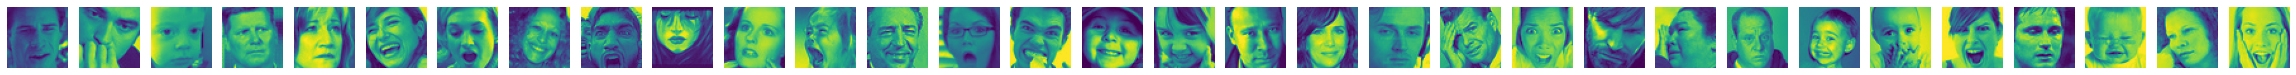

angry   sad   neutral   angry   fear   happy   surprise   happy   angry   sad   fear   sad   happy   surprise   angry   happy   angry   neutral   happy   neutral   angry   fear   angry   sad   sad   happy   fear   fear   sad   sad   sad   surprise   

In [16]:
# Extracting next batch to plot it, this batch of photos are selected randomly

imgs,lables=next(train_gen)

# list of Classes

list_of_keys=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']                  

def plotImages(images_arr):
  fig, axes= plt.subplots(1,32,figsize=(32,2))
  axes= axes.flatten()
  for img, ax in zip(images_arr,axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()
plotImages(imgs)

# Printing the lables below the respective image

for i in lables[:32]:                                                                             
  for num, j in enumerate(i):
    if j==1:
      print(list_of_keys[num], end='   ')  # Labelling seems to be spot on                                                            
num+=1